# MVC project: Get the Data
- [GitHub](https://github.com/romainmartinez/mvc)

## Todo:
- plot model mean + sd
- test other metrics
- test set for each muscle (% for each muscle & mean + sd for all muscles)
- article:
    - w/ 5 tests and this method: 93%
    - w/ 5 tests and old method: 85%
    - to get same metrics without prediction, need 12 tests

## 0. Setup

In [1]:
# Common imports
import pandas as pd
import numpy as np
import os
import time

# the 'mvc' directory contains functions used but not necessary to understand the story
import mvc

# Figures
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set_context("paper")

# to make this notebook's output stable across runs
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## 1. Load data

In [2]:
df = pd.read_hdf('mvc.h5')
df.head()

,upper trapezius,middle trapezius,lower trapezius,anterior deltoid,middle deltoid,posterior deltoid,pectoralis major,serratus anterior,latissimus dorsi,supraspinatus,...,8,9,10,11,12,13,14,15,max,best_test
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104184,4
1,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.135626,1
2,0,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300761,2
3,0,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262121,3
4,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.170468,2


### Drop tests
*see '`2_select_test.ipynb`' notebook*

In [3]:
# tests to drop according to previous analysis (2_select_test.ipynb)
to_keep = np.array(['4', '3', '2', '0', '5']).astype(int)
to_drop = np.delete(np.arange(16), to_keep)
df.drop(to_drop, axis=1, inplace=True)

## 2. Split the data

### Cross-Validation

In [4]:
from sklearn.model_selection import cross_val_score

In [5]:
def display_scores(scores):
    # we rectify the scores because cross_val_score expect a utility function (greater is better)
    # rather than a cost function (lower is better)
    scores_rectified = np.sqrt(-scores)
    print(f'Scores: {scores_rectified}')
    print(f'Mean: {scores_rectified.mean()}')
    print(f'STD: {scores_rectified.std()}')

### Stratified Train Test Split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_labels = list(df.drop(['max', 'muscle', 'best_test'], axis=1).columns)
y_labels = ['max']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[X_labels], df[y_labels], test_size=0.2, random_state=RANDOM_SEED,
                                       stratify=df['muscle'])

## 3. Select and Train Models

In [9]:
# linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
# trees
from sklearn.tree import DecisionTreeRegressor
# ensemble
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
# support vector
from sklearn.svm import SVR

In [10]:
models = {
    # linear models
    'lin_reg': LinearRegression(),
    'sgd': SGDRegressor(random_state=RANDOM_SEED, max_iter=1000),
    'lasso': Lasso(random_state=RANDOM_SEED),
    'elasticnet': ElasticNet(random_state=RANDOM_SEED),
    'ridge': Ridge(random_state=RANDOM_SEED),
    # trees
    'dtr': DecisionTreeRegressor(random_state=RANDOM_SEED),
    # ensemble
    'adaboost': AdaBoostRegressor(random_state=RANDOM_SEED),
    'bagging': BaggingRegressor(random_state=RANDOM_SEED),
    'randforest': RandomForestRegressor(random_state=RANDOM_SEED),
    'extratree': ExtraTreesRegressor(random_state=RANDOM_SEED),
    'gradientboosting': GradientBoostingRegressor(),
    # support vector
    'svr': SVR(kernel='linear')
}

In [30]:
# compare models
names, means, stds, times = [[] for i in range(4)]

for name, model in models.items():
    start = time.time()
    scores = cross_val_score(model, X_train, np.ravel(y_train),
                        scoring='neg_mean_squared_error', cv=10)
    end = time.time()
    execution_time = end - start
    
    # we rectify the scores because cross_val_score expect a utility function (greater is better)
    # rather than a cost function (lower is better)
    scores_rectified = np.sqrt(-scores) 
    
    names.append(name)
    print(name.upper())
    
    means.append(scores_rectified.mean())
    stds.append(scores_rectified.std())
    
    times.append(execution_time)
    print(f'execution time: {execution_time:.3f} sec')
    
    print('-' * 10)

LIN_REG
execution time: 0.072 sec
----------
SGD
execution time: 1.268 sec
----------
LASSO
execution time: 0.017 sec
----------
ELASTICNET
execution time: 0.017 sec
----------
RIDGE
execution time: 0.019 sec
----------
DTR
execution time: 0.062 sec
----------
ADABOOST
execution time: 0.805 sec
----------
BAGGING
execution time: 0.377 sec
----------
RANDFOREST
execution time: 0.375 sec
----------
EXTRATREE
execution time: 0.261 sec
----------
GRADIENTBOOSTING
execution time: 0.791 sec
----------
SVR
execution time: 0.318 sec
----------


In [31]:
metrics = pd.DataFrame({'mean': means,
                        'std': stds,
                        'time': times},
                      index=names)
metrics.sort_values(by='mean', inplace=True)

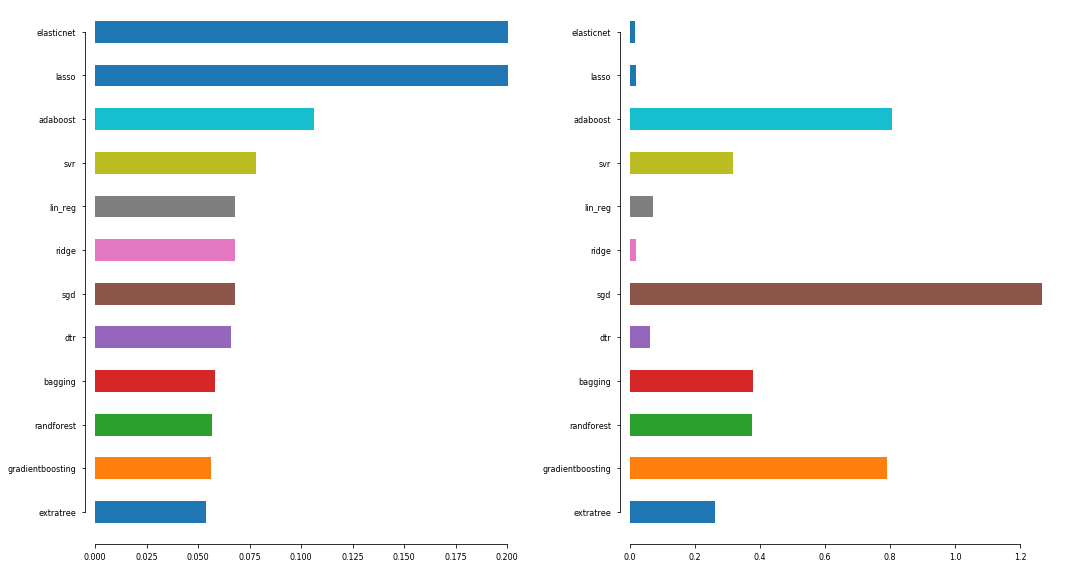

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
metrics['mean'].plot(kind='barh', ax=ax1)
metrics['time'].plot(kind='barh', ax=ax2)

sns.despine(offset=10, trim=True)
fig.tight_layout()
plt.show()

## 4. Fine-tune the model

### Grid search

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

In [26]:
forest_reg = RandomForestRegressor(random_state=RANDOM_SEED)

In [27]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error')

In [28]:
grid_search.fit(X_train, np.ravel(y_train))

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [29]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

### Randomized Grid Search

In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [31]:
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

In [32]:
forest_reg = RandomForestRegressor(random_state=RANDOM_SEED)

In [33]:
n_iter_search = 100
random_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                   n_iter=n_iter_search, cv=5, random_state=RANDOM_SEED,
                                   scoring='neg_mean_squared_error')

In [34]:
random_search.fit(X_train, np.ravel(y_train))

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb629fb0128>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb629b09358>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [35]:
random_search.best_params_

{'max_features': 7, 'n_estimators': 122}

In [36]:
features_importances = random_search.best_estimator_.feature_importances_
print('features importances:')
sorted(zip(features_importances, X_train.columns), reverse=True)

features importances:


[(0.32067511302534896, 4),
 (0.23153615955548479, 2),
 (0.1761616038487521, 3),
 (0.13100677311652298, 5),
 (0.11566527762236964, 0),
 (0.0049495887993664346, 'pectoralis major'),
 (0.0045823480752113042, 'posterior deltoid'),
 (0.0030864183334295115, 'upper trapezius'),
 (0.0028663927690543043, 'latissimus dorsi'),
 (0.0023957873041145221, 'subscapularis'),
 (0.0017586317018280417, 'infraspinatus'),
 (0.0016912597952494096, 'middle trapezius'),
 (0.0010474860350924253, 'serratus anterior'),
 (0.00095183741101077443, 'lower trapezius'),
 (0.00066010029122864596, 'middle deltoid'),
 (0.0005324016099468613, 'anterior deltoid'),
 (0.00043282070598939812, 'supraspinatus')]

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

In [38]:
final_model = random_search.best_estimator_

final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f'final rmse: {final_rmse}')

final_variance = explained_variance_score(y_test, final_predictions)
print(f'explained variance: {final_variance}')

final_r2 = r2_score(y_test, final_predictions)
print(f'r2: {final_r2}')

final rmse: 0.04848342331643601
explained variance: 0.9338460409775506
r2: 0.9336784584066791
